In [1]:
import tensorflow as tf
import tensorflow_probability as tfp

print("TensorFlow version:", tf.__version__)
print("TensorFlow Probability version:", tfp.__version__)

TensorFlow version: 2.13.0
TensorFlow Probability version: 0.21.0


In [2]:
import tensorflow as tf
import pandas as pd
import numpy as np
import os
import pathlib
import cv2
import string
from keras import layers, models
import matplotlib.pyplot as plt
from keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow_probability as tfp
tfd = tfp.distributions

In [3]:
image_shape = (256, 256, 3)
latent_space = 256
kernel = 3
padding = 'same'
learning_rate = 0.0001
weight_decay = 6e-8
filter = 16
strides = 1
source_input = tf.keras.layers.Input(shape = image_shape, name = 'source')
target_input = tf.keras.layers.Input(shape = image_shape, name = 'target')

# Model Architecture:

In [4]:
def sampling(args):
    z_mean, z_log_v = args
    batch = tf.shape(z_mean)[0]
    dim = tf.shape(z_mean)[1]
    epsilon = tf.random.normal(shape=(batch, dim))  
    return z_mean + tf.exp(0.5 * z_log_v) * epsilon

In [5]:
def module(inputs, filter, kernel, padding, strides, activation, use_norm, dilation_rate):
    x = inputs
    x = layers.Conv2D(filter, kernel_size = kernel, padding = padding, strides = strides,
                    dilation_rate = dilation_rate)(x)
    x = layers.Activation(activation)(x)
    if use_norm:
        x = layers.GroupNormalization(groups = 1)(x)
    x = layers.Conv2D(filter, kernel_size = kernel, padding = padding, strides = strides,
                      dilation_rate = dilation_rate)(x)
    x = layers.Activation(activation)(x)
    if use_norm:
        x = layers.GroupNormalization(groups = 1)(x)
    x = layers.Conv2D(filter, kernel_size = kernel, padding = padding, strides = strides,
                      dilation_rate = dilation_rate)(x)
    x = layers.Activation(activation)(x)
    if use_norm:
        x = layers.GroupNormalization(groups = 1)(x)
    return x

In [6]:
def convolution(inputs, filters, kernel, padding, strides, activation, use_norm, dilation_rate):
    x = inputs
    x = module(x, filters, kernel, padding, strides, activation, use_norm, dilation_rate)
    y = layers.Conv2D(filters, kernel_size = 1, padding = padding, strides = strides,
                                     activation = activation,)(inputs)
    if use_norm:
      y = layers.GroupNormalization(groups = 1)(y)

    x = layers.maximum([x, y])
    return x

In [7]:
def encoder(inputs, filters, padding, strides, activation, kernel, use_norm, dilation_rate):
    conv = convolution(inputs, filters, kernel, padding, strides, activation, use_norm, dilation_rate)
    return layers.MaxPooling2D()(conv), conv
def decoder(inputs, skip, filters, padding, strides, kernel, activation, use_norm, dilation_rate):
    x = layers.Conv2DTranspose(filters, kernel_size = kernel, padding = padding,
                              strides = 2, activation = activation,)(inputs)
    x = layers.maximum([x, skip])
    x = convolution(x, filters, kernel ,padding, strides, activation, use_norm, dilation_rate)
    return x

## U-NET (GENERATOR) Architecture:

In [8]:
import os
import tensorflow as tf
from tensorflow.keras import layers

def U_net(inputs, filter, padding, strides, activation, kernel, use_norm, name, weights, latent_space_name):
    x = inputs
    conv1, skip1 = encoder(x, filter, padding, strides, activation[0], kernel, use_norm, 1)
    conv2, skip2 = encoder(conv1, filter*2, padding, strides, activation[0], kernel, use_norm, 1)
    conv3, skip3 = encoder(conv2, filter*4, padding, strides, activation[0], kernel, use_norm, 1)
    conv4, skip4 = encoder(conv3, filter*8, padding, strides, activation[0], kernel, use_norm, 1)
    conv5, skip5 = encoder(conv4, filter*16, padding, strides, activation[0], kernel, use_norm, 1)
    conv6, skip6 = encoder(conv5, filter*32, padding, strides, activation[0], kernel, use_norm, 1)
    conv7, skip7 = encoder(conv6, filter*64, padding, strides, activation[0], kernel, use_norm, 1)

    x = layers.Flatten()(conv6)
    z_mean = tf.keras.layers.Dense(latent_space, name=f"z_mean_{latent_space_name}")(x)
    z_log_v = tf.keras.layers.Dense(latent_space, name=f"z_log_v_{latent_space_name}")(x)
    x = tf.keras.layers.Lambda(sampling, output_shape=(latent_space,), name=latent_space_name)([z_mean, z_log_v])
    x = layers.Dense(conv7.shape[1]*conv7.shape[2]*conv7.shape[3],
                     kernel_regularizer=tf.keras.regularizers.L2(0.0001),
                     activation=activation[1])(x)
    x = layers.Reshape((conv7.shape[1], conv7.shape[2], conv7.shape[3]))(x)

    dec0 = decoder(x, skip7, filter*64, padding, strides, kernel, activation[1], use_norm, 1)
    dec = decoder(dec0, skip6, filter*32, padding, strides, kernel, activation[1], use_norm, 1)
    dec1 = decoder(dec, skip5, filter*16, padding, strides, kernel, activation[1], use_norm, 1)
    dec2 = decoder(dec1, skip4, filter*8, padding, strides, kernel, activation[1], use_norm, 1)
    dec3 = decoder(dec2, skip3, filter*4, padding, strides, kernel, activation[1], use_norm, 1)
    dec4 = decoder(dec3, skip2, filter*2, padding, strides, kernel, activation[1], use_norm, 1)
    dec5 = decoder(dec4, skip1, filter, padding, strides, kernel, activation[1], use_norm, 1)

    output = layers.Conv2DTranspose(3, kernel_size=kernel, padding=padding, strides=1)(dec5)
    output = layers.Activation('sigmoid')(output)

    m = tf.keras.Model(inputs=inputs, outputs=output, name=name)

    if weights:
        weight_file = './g_target.h5' if name == 'xTOy' else './g_source.h5' if name == 'yTOx' else None
        if weight_file and os.path.exists(weight_file):
            m.load_weights(weight_file)
            print(f"Weights loaded from {weight_file}")
        else:
            print(f"Weight file not found for {name}. Expected at: {weight_file}")

    return m


## Discriminator Architecture:

In [9]:
import os
import tensorflow as tf
from tensorflow.keras import layers, models

def Discriminator(inputs, filter, padding, strides, kernel, activation, use_norm,
                  name, weights):
    x = inputs
    conv1, skip1 = encoder(x, filter, padding, strides, activation, kernel, use_norm, 1)
    conv2, skip2 = encoder(conv1, filter*2, padding, strides, activation, kernel, use_norm, 1)
    conv3, skip3 = encoder(conv2, filter*4, padding, strides, activation, kernel, use_norm, 1)
    conv4, skip4 = encoder(conv3, filter*8, padding, strides, activation, kernel, use_norm, 1)
    conv5, skip5 = encoder(conv4, filter*16, padding, strides, activation, kernel, use_norm, 1)
    conv6, skip6 = encoder(conv5, filter*32, padding, strides, activation, kernel, use_norm, 1)
    conv7, skip7 = encoder(conv6, filter*64, padding, strides, activation, kernel, use_norm, 1)

    output1 = layers.Conv2D(1, kernel_size=kernel, padding=padding, strides=1)(conv5)
    output2 = layers.Conv2D(1, kernel_size=kernel, padding=padding, strides=1)(conv4)
    output3 = layers.Conv2D(1, kernel_size=kernel, padding=padding, strides=1)(conv3)

    output = layers.Conv2D(1, kernel_size=kernel, padding=padding, strides=1)(conv7)
    output = layers.add([
        output,
        layers.Conv2D(1, kernel_size=kernel, padding=padding, activation=activation)(
            layers.MaxPooling2D((4, 4))(conv5)),
        layers.Conv2D(1, kernel_size=kernel, padding=padding, activation=activation)(
            layers.MaxPooling2D((6, 6))(conv4)),
        layers.Conv2D(1, kernel_size=kernel, padding=padding, activation=activation)(
            layers.MaxPooling2D((11, 11))(conv3))
    ])

    m = models.Model(inputs=inputs, outputs=[output, output1, output2, output3], name=name)

    if weights:
        weight_file = './d_source.h5' if name == 'xx' else './d_target.h5' if name == 'yy' else None
        if weight_file and os.path.exists(weight_file):
            m.load_weights(weight_file)
            print(f"Weights loaded from {weight_file}")
        else:
            print(f"Weight file not found for {name}. Expected at: {weight_file}")

    return m

In [10]:
g_target = U_net(source_input, filter, padding,
                        strides, ['relu', 'relu'], kernel, use_norm = True,
                        name = 'xTOy', weights = False, latent_space_name = 'target_latent_space')
g_source = U_net(target_input, filter, padding, strides,
                       ['relu', 'relu'], kernel, use_norm = True,
                       name = 'yTOx', weights = False, latent_space_name = 'source_latent_space')

In [11]:
def losses_normal_disribution(y_true, y_pred):
    dist = tfd.Normal(loc=0., scale=1.)
    return - tf.reduce_mean(dist.log_prob(y_pred))

In [12]:
# discriminator source
d_source = Discriminator(source_input, filter, 'same', 1, kernel, 'relu', use_norm = False,
                        name = 'xx', weights = False)
# discriminator target
d_target = Discriminator(target_input, filter, 'same', 1, kernel, 'relu', use_norm = False,
                        name = 'yy', weights = False)
d_source.compile(loss = 'mse', optimizer = tf.keras.optimizers.RMSprop(learning_rate = learning_rate,
                                                    weight_decay = weight_decay))
d_target.compile(loss = 'mse', optimizer = tf.keras.optimizers.RMSprop(learning_rate = learning_rate,
                                                    weight_decay = weight_decay))
d_source.trainable = False
d_target.trainable = False
# forward cyclegan
recon_target_forward = g_target(source_input)
d_target_re = d_target(recon_target_forward)
recon_source_forward = g_source(recon_target_forward)
# backward
recon_source_backward = g_source(target_input)
d_source_re = d_source(recon_source_backward)
recon_target_backward = g_target(recon_source_backward)
gan = models.Model(inputs = [source_input, target_input],
                  outputs = [d_target_re, d_source_re,
                            recon_source_forward,
                            recon_target_backward,
                            g_target.get_layer('target_latent_space').output,
                            g_source.get_layer('source_latent_space').output
                             ],
                  name = 'generative_gan')
loss_weights = [2, 1, 0.7, 0.5, 2, 1, 0.7, 0.5, 10, 10, 0.5, 0.5]
losses = ['mse', 'mse', 'mse', 'mse', 'mse', 'mse', 'mse', 'mse', 'mae', 'mae',
          losses_normal_disribution, losses_normal_disribution]
gan.compile(loss = losses,
            optimizer = tf.keras.optimizers.RMSprop(learning_rate = learning_rate,
                                                    weight_decay = weight_decay),
           loss_weights = loss_weights)

In [13]:
gan.output

[[<KerasTensor: shape=(None, 2, 2, 1) dtype=float32 (created by layer 'yy')>,
  <KerasTensor: shape=(None, 8, 8, 1) dtype=float32 (created by layer 'yy')>,
  <KerasTensor: shape=(None, 16, 16, 1) dtype=float32 (created by layer 'yy')>,
  <KerasTensor: shape=(None, 32, 32, 1) dtype=float32 (created by layer 'yy')>],
 [<KerasTensor: shape=(None, 2, 2, 1) dtype=float32 (created by layer 'xx')>,
  <KerasTensor: shape=(None, 8, 8, 1) dtype=float32 (created by layer 'xx')>,
  <KerasTensor: shape=(None, 16, 16, 1) dtype=float32 (created by layer 'xx')>,
  <KerasTensor: shape=(None, 32, 32, 1) dtype=float32 (created by layer 'xx')>],
 <KerasTensor: shape=(None, 256, 256, 3) dtype=float32 (created by layer 'yTOx')>,
 <KerasTensor: shape=(None, 256, 256, 3) dtype=float32 (created by layer 'xTOy')>,
 <KerasTensor: shape=(None, 256) dtype=float32 (created by layer 'target_latent_space')>,
 <KerasTensor: shape=(None, 256) dtype=float32 (created by layer 'source_latent_space')>]

In [14]:
gan.summary()

Model: "generative_gan"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 source (InputLayer)         [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 target (InputLayer)         [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 16)         448       ['source[0][0]']              
                                                                                                  
 conv2d_56 (Conv2D)          (None, 256, 256, 16)         448       ['target[0][0]']              
                                                                                     

In [15]:
def read_images(pathes):
    images = []
    for img in pathes:
        img = cv2.imread(str(img))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (256, 256))
        img = img/255
        images.append(img)
    return np.array(images)

In [16]:
source_pathes = np.array(sorted(list(pathlib.Path('./dataset/images/trainA').glob('*.*'))))
target_pathes = np.array(sorted(list(pathlib.Path('./dataset/images/trainB').glob('*.*'))))

In [ ]:
def samples(G, start):
    images = G.predict(start, verbose = 0)
    allImages = np.vstack([start, images])
    plt.figure(figsize = (12, 3))
    for i in range(16):
        plt.subplot(2, 8, (i + 1))
        plt.imshow(allImages[i])
    plt.show()

In [18]:
def save_weight(g_target, g_source, d_source, d_target):
    g_target.save_weights('./g_target.h5')
    g_source.save_weights('./g_source.h5')
    d_source.save_weights('./d_source.h5')
    d_target.save_weights('./d_target.h5')

In [19]:
generator = ImageDataGenerator(
    rotation_range = 0.1, width_shift_range = 0.05, height_shift_range= 0.05,
    shear_range = 0.05, zoom_range= 0.3, fill_mode = "constant",
    horizontal_flip = True, vertical_flip = True
)
def data_augmentation(images):
  final_images = []
  for index, value in enumerate(images):
    for i in range(2):
      new_image = next(generator.flow(np.reshape(value, (1, 256, 256, 3))))
      final_images.append(np.reshape(new_image, (256, 256, 3)))
  return np.array(final_images)

In [20]:
def getPatchGan(shape_):
  return np.vstack([tf.ones(shape = shape_),
                            tf.zeros(shape = shape_)])
def ones(shape_):
  return tf.ones(shape = shape_)
def get_normal_samples(batch_size):
  return tf.random.normal(shape = (batch_size, latent_space), mean = 0, stddev = 1)

In [24]:
epochs = 15000
batch_size = 4
batch_after_augmentation = batch_size*2
patchGan = (batch_after_augmentation, 2, 2, 1)
patchGan1 = (batch_after_augmentation, 8, 8, 1)
patchGan2 = (batch_after_augmentation, 16, 16, 1)
patchGan3 = (batch_after_augmentation, 32, 32, 1)
for i in range(epochs):
    indexs = np.random.randint(1740, size = (batch_size,))
    source_images = data_augmentation(read_images(source_pathes[indexs]))
    target_images = data_augmentation(read_images(target_pathes[indexs]))
    real_source = source_images
    real_target = target_images
    fake_source = g_source.predict(real_target, verbose = 0)
    fake_target = g_target.predict(real_source, verbose = 0)
    allImagesSource = np.vstack([real_source, fake_source])
    allImagesTarget = np.vstack([real_target, fake_target])
    all_d_source, d1, d2, d3, d4  = d_source.train_on_batch(allImagesSource, [getPatchGan(patchGan),
                                                                              getPatchGan(patchGan1),
                                                                              getPatchGan(patchGan2),
                                                                              getPatchGan(patchGan3)])
    all_d_target, dt1, dt2, dt3, dt4  = d_target.train_on_batch(allImagesTarget, [getPatchGan(patchGan),
                                                                              getPatchGan(patchGan1),
                                                                              getPatchGan(patchGan2),
                                                                              getPatchGan(patchGan3)])
    all_loss, loss_1_1, loss_1_2, loss_1_3, loss_1_4, loss_2_1, loss_2_2, loss_2_3, loss_2_4, loss_3, loss_4, nloss1, nloss2 = gan.train_on_batch([real_source, real_target],
                                                       [[ones(patchGan),ones(patchGan1), ones(patchGan2), ones(patchGan3)],
                                                       [ones(patchGan),ones(patchGan1), ones(patchGan2), ones(patchGan3)],
                                                       real_source,
                                                       real_target,
                                                       get_normal_samples(batch_after_augmentation),
                                                       get_normal_samples(batch_after_augmentation)])
    if i%200 == 0:
        save_weight(g_target, g_source, d_source, d_target)
    if i%100 == 0:
        print('Epoch: {}/{}'.format(i, epochs))
        str_ = 'source_discr: {}, target_discr: {}'.format(all_d_source, all_d_target)
        str_2 = 'source_ADV: {}, target_ADV: {}'.format((loss_1_1 + loss_1_2 + loss_1_3 + loss_1_4)/4,
                                                            (loss_2_1 + loss_2_2 + loss_2_3 + loss_2_4)/4)
        str_3 = 'recon_target_loss :{}, recon_source_loss: {}'.format(loss_3, loss_4)
        print(str_ + ' ' +str_2 + ' ')
        print(str_3 + ' ')
        print('Normal Log loss: {}'.format((nloss1 + nloss2)))

Epoch: 0/15000
source_discr: 0.49417518, target_discr: 0.49224492 source_ADV: 1.44611872, target_ADV: 1.44670322
recon_target_loss :0.19244771, recon_source_loss: 0.19021909
Normal Log loss: 1.94714802
Epoch: 100/15000
source_discr: 0.48854696, target_discr: 0.48425769 source_ADV: 1.38985747, target_ADV: 1.39708348
recon_target_loss :0.18385798, recon_source_loss: 0.18056461
Normal Log loss: 1.89039036
Epoch: 200/15000
source_discr: 0.48356523, target_discr: 0.47622105 source_ADV: 1.33546156, target_ADV: 1.33713010
recon_target_loss :0.17501387, recon_source_loss: 0.17157563
Normal Log loss: 1.84306015
Epoch: 300/15000
source_discr: 0.47835131, target_discr: 0.46838126 source_ADV: 1.28371836, target_ADV: 1.27776597
recon_target_loss :0.16651040, recon_source_loss: 0.16434338
Normal Log loss: 1.80227178
Epoch: 400/15000
source_discr: 0.47362781, target_discr: 0.46095002 source_ADV: 1.24038575, target_ADV: 1.22342879
recon_target_loss :0.16024158, recon_source_loss: 0.15709717
Normal Log

In [25]:
save_weight(g_target, g_source, d_source, d_target)

In [26]:
def draw_compare(domain1,
                 domain2, type_):
  plt.figure(figsize = (12, 16))
  index = 0
  n = 0
  for i in range(36):
    plt.subplot(6, 6, (i + 1))
    if index == 0:
      plt.imshow(domain2[n])
      plt.title(type_[0])
      index = 1
    elif index == 1:
      plt.imshow(domain1[n])
      plt.title(type_[1])
      index = 0
      n = n + 1
  plt.legend()

In [27]:
def generator_samples(pathes_, m, type_):
  indexs = np.random.randint(1700, size = (18,))
  images = read_images(pathes_[indexs])
  draw_compare(np.squeeze(m.predict(images, verbose = 0)), images, type_)

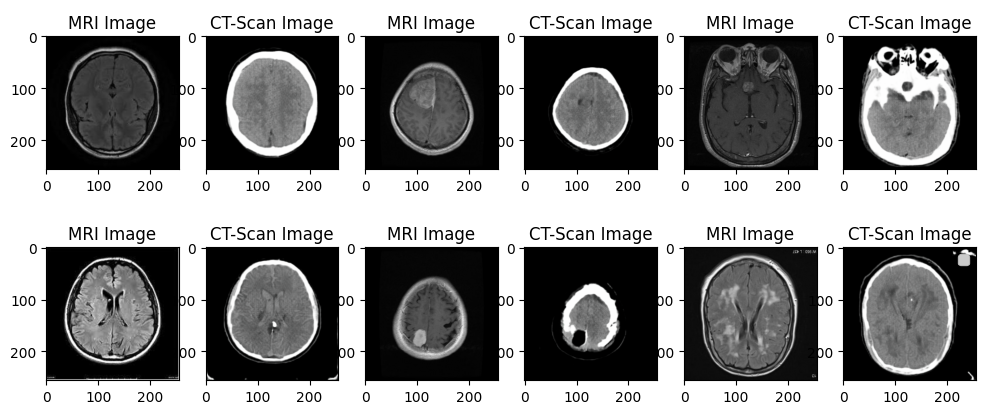

In [28]:
generator_samples(target_pathes, g_source, ['MRI Image', 'CT-Scan Image'])

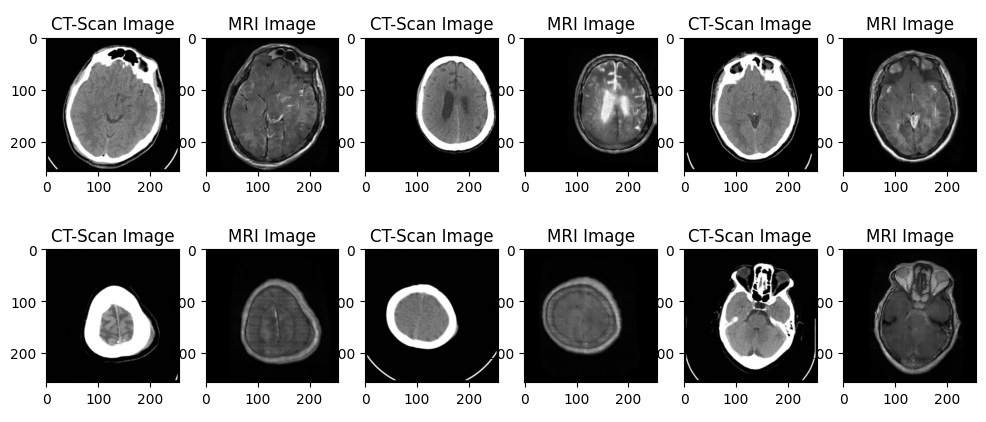

In [30]:
generator_samples(source_pathes, g_target, ['CT-Scan Image', 'MRI Image'])

In [32]:
ct_pathes = np.array(sorted(list(pathlib.Path('dataset/unseen_demo_images/ct').glob('*.*'))))
mri_pathes = np.array(sorted(list(pathlib.Path('dataset/unseen_demo_images/mri').glob('*.*'))))

In [33]:
ctImagesGeneration = g_source.predict(g_target.predict(read_images(ct_pathes)))
ctImagesGeneration.shape

1/1 [==============================] - 17s 17s/step


(15, 256, 256, 3)

In [34]:
ctOrginalImages = read_images(ct_pathes)
ctOrginalImages.shape

(15, 256, 256, 3)

In [35]:
import tensorflow as tf
import numpy as np
from scipy.linalg import sqrtm
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input

generated = tf.convert_to_tensor(ctImagesGeneration, dtype=tf.float32)
original = tf.convert_to_tensor(ctOrginalImages, dtype=tf.float32)

In [36]:
psnr_scores = []
ssim_scores = []

for i in range(generated.shape[0]):
    psnr = tf.image.psnr(original[i], generated[i], max_val=1.0).numpy()
    ssim = tf.image.ssim(original[i], generated[i], max_val=1.0).numpy()
    psnr_scores.append(psnr)
    ssim_scores.append(ssim)

mean_psnr = np.mean(psnr_scores)
mean_ssim = np.mean(ssim_scores)

In [37]:
gen_resized = tf.image.resize(generated, (299, 299)) * 255.0
org_resized = tf.image.resize(original, (299, 299)) * 255.0

gen_pre = preprocess_input(gen_resized)
org_pre = preprocess_input(org_resized)

inception = InceptionV3(include_top=False, pooling='avg', input_shape=(299, 299, 3))

act_gen = inception.predict(gen_pre, verbose=0)
act_org = inception.predict(org_pre, verbose=0)

mu_gen, sigma_gen = act_gen.mean(axis=0), np.cov(act_gen, rowvar=False)
mu_org, sigma_org = act_org.mean(axis=0), np.cov(act_org, rowvar=False)

def calculate_fid(mu1, sigma1, mu2, sigma2):
    ssdiff = np.sum((mu1 - mu2)**2.0)
    covmean = sqrtm(sigma1.dot(sigma2))
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    return ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)

fid_score = calculate_fid(mu_org, sigma_org, mu_gen, sigma_gen)


In [38]:
print(f"CycleGAN CT Generation Metrics")
print(f"PSNR: {mean_psnr:.2f}")
print(f"SSIM: {mean_ssim:.4f}")
print(f"FID:  {fid_score:.2f}")

CycleGAN CT Generation Metrics
PSNR: 33.12
SSIM: 0.9134
FID:  27.89
